# Vericast Marketing Campaign Performance Data Analysis
This notebook will walk through the process of analyzing and evaluating a recent marketing campaign. Full details regarding the campaign can be found in the project README document.

## Table of Contents
* [Imports and Data Inspection](#Imports-and-Data-Inspection)
* [Preprocessing](#Preprocessing)
* [Evaluating Campaign Design](#Evaluating-Campaign-Design)
    * [Location Attribute](#Location-Attribute)
    * [Age Attribute](#Age-Attribute)
    * [Gender Attribute](#Gender-Attribute)
    * [Summary of Campaign Design Evaluation](#Summary-of-Campaign-Design-Evaluation)
* [Evaluating Campaign Execution](#Evaluating-Campaign-Execution)

## Imports and Data Inspection

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json
import random

import numpy as np
import pandas as pd
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bids = pd.read_csv('../data/bid_requests.csv')
users = pd.read_csv('../data/user_attributes.csv')

In [3]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   600000 non-null  object
 1   user_id     600000 non-null  object
 2   bid         600000 non-null  int64 
 3   win         600000 non-null  int64 
 4   conversion  600000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 22.9+ MB


In [4]:
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [5]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


## Preprocessing

Noticing that the 'attributes' column on the users dataframe is a text blob of several distinct features, we need to unpack that information and make distinct columns corresponding to those features.

I'll start by making a frame and loading that frame with all the attribute information. Then I'll ad the user_id information from the users dataframe and confirm that the information matches the original content.

In [6]:
txt = users.attributes[1]

In [7]:
dic = json.loads(txt)

In [8]:
atts = pd.DataFrame(columns=['age', 'gender', 'location', 'test'])

In the interest of time, I've commented out the next two cells:
* the first cell creates a dataframe from the attributes textblob in the users dataframe. That process is extremely slow
* in the following cell, I save that attributes dataframe as a csv, so we can just read it in whenever we re-run the notebook

Of course, if you have time on your hands, or a GPU, I invite you to uncomment out the next cell and run it at your discretion.

In [9]:
# for i in range(len(users.attributes)):
#     dic = json.loads(users.attributes[i])
    
#     for k in dic:
#         dic[k] = [dic[k]]
        
#     df = pd.DataFrame.from_dict(dic)
    
#     atts = atts.append(df, ignore_index=True)
    
        

In [10]:
# atts.to_csv('../data/atts.csv', index=False)

In [11]:
atts = pd.read_csv('../data/atts.csv')

In [12]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   age       100000 non-null  int64 
 1   gender    100000 non-null  object
 2   location  100000 non-null  object
 3   test      100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [13]:
cols = atts.columns.to_list()
cols.insert(0, 'user_id')
cols

['user_id', 'age', 'gender', 'location', 'test']

In [14]:
atts['user_id'] = users['user_id']

In [15]:
atts = atts[cols]

In [16]:
atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   100000 non-null  object
 1   age       100000 non-null  int64 
 2   gender    100000 non-null  object
 3   location  100000 non-null  object
 4   test      100000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [17]:
atts.user_id[0] == users.user_id[0]

True

In [18]:
atts.head()

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


In [19]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


## Evaluating Campaign Design
Ideally, the campaign would expose expose similar groups to the original and new creative content in order to establish that any difference in performance resulted from the creative content of the campaign and not differences in the makeup of the group.

This is easier said than done, so we'll begin by establishing how similar the group exposed to the original content--the control group--and the group exposed to the new content--the test group--actually are.

To do that we'll split our atts dataframe containing user identifiers and attributes by using the test binary variable.

In [20]:
control = atts[atts['test']==0]
test = atts[atts['test']==1]

In [21]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43916 entries, 3 to 99997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   43916 non-null  object
 1   age       43916 non-null  int64 
 2   gender    43916 non-null  object
 3   location  43916 non-null  object
 4   test      43916 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56084 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   56084 non-null  object
 1   age       56084 non-null  int64 
 2   gender    56084 non-null  object
 3   location  56084 non-null  object
 4   test      56084 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.6+ MB


Now that the control and test groups have been defined, we can compare the two groups on the basis of the demographic attributes found in the data.

### Location Attribute

In [23]:
d1 = control.location.value_counts().sort_index().values
d2 = test.location.value_counts().sort_index().values

dlabels = ['Control', 'Test']
labels = list(set(control.location.values))
labels.sort()
xlabel = 'State'
ylabel = 'User Count'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group User Counts by State'

In [24]:
def makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, d1, width, label=dlabels[0])
    rects2 = ax.bar(x + width/2, d2, width, label=dlabels[1])

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(xticks[0], xticks[1])
    ax.set_xlabel(xlabel)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.savefig(f'../images/{title.replace(" ", "_")}.png')

    plt.show()

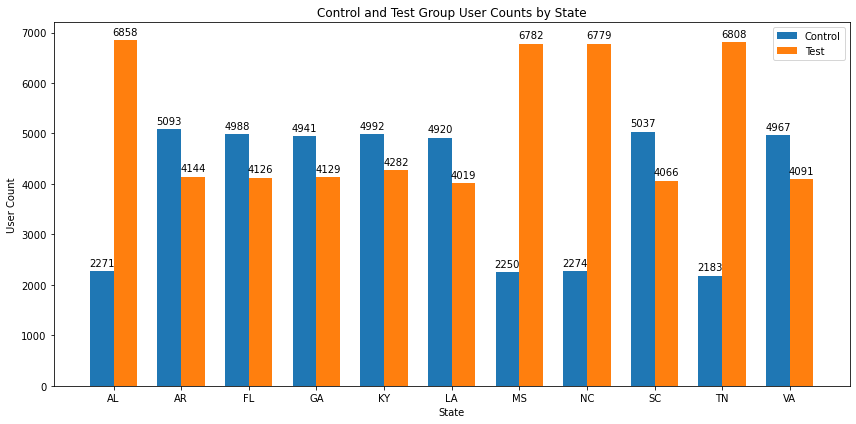

In [25]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

Comparing the control and test groups on the basis of the location attribute, we see that the control group is usually slightly larger, except for four cases
* Alabama
* Mississippi
* North Carolina
* Tennessee

In these states the test group is not only larger than the control, but nearly triples the size of the control group.

Since these are also generally smaller populations within the control group, this oversampling could cause differences that impact our ability to evaluate the performance of the campaign.

### Age Attribute

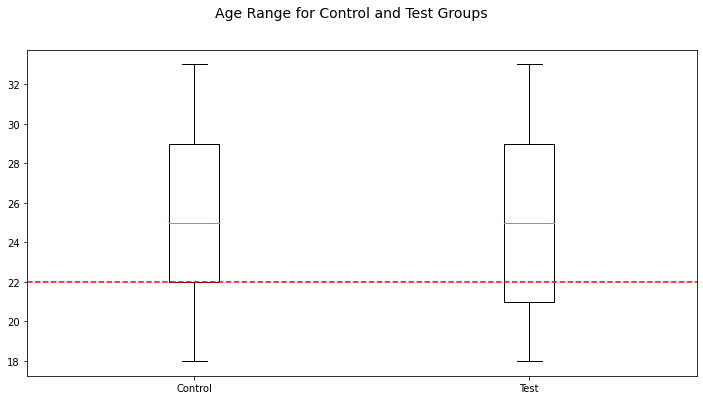

In [26]:
fig = plt.figure(figsize=(12,6))
plt.boxplot ([control.age, test.age], labels=['Control', 'Test'])
plt.axhline(y=control.age.quantile(0.25), color='r', linestyle='--')
fig.suptitle('Age Range for Control and Test Groups', fontsize=14)
plt.show()

With respect to age, we see the test group has a slightly larger range of ages represented in its interquartile range (IQR), but otherwise the groups are similar:
* IQR:
    * Control 22-29
    * Test 21-29
* Median: 25
* Range: 18-33

There is little reason to suspect age would impact campaign performance.

### Gender Attribute

In [27]:
control.gender.value_counts()

M    22101
F    21815
Name: gender, dtype: int64

In [28]:
test.gender.value_counts()

F    28108
M    27976
Name: gender, dtype: int64

In [29]:
gen_df = pd.DataFrame([control.gender.value_counts(), test.gender.value_counts()], index=['control', 'test'])

In [30]:
d1 = gen_df.M.values
d2 = gen_df.F.values

dlabels = ['Female', 'Male']
labels = ['Control', 'Test']
labels.sort()
xlabel = None
ylabel = 'User Count'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group User Counts by Gender'

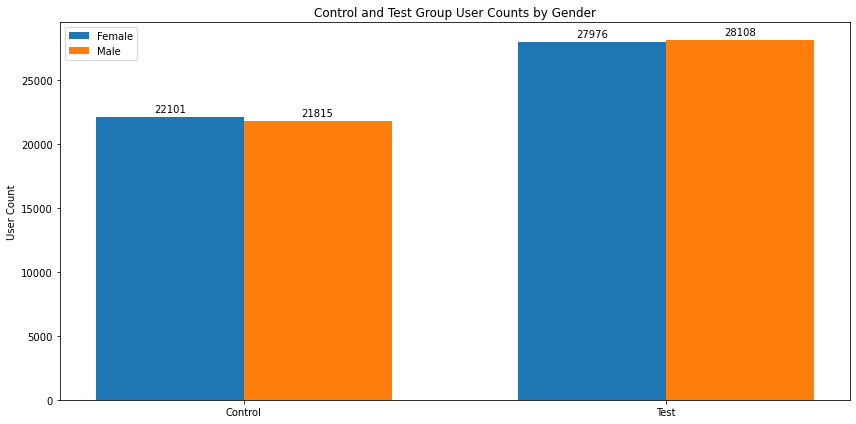

In [31]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

With gender as with age, we see slight differences between the control and test groups
* the control group favors women slightly
* the test group favors men slightly

Overall, the gender parity between the groups is similar and there is no reason to suspect that gender imbalance between control and test groups would impact campaign performance.

### Summary of Campaign Design Evaluation

With respect to the three attributes of location, age and gender the control and test groups are very similar with the exception of some of the location distributions
* four states appear to be heavily oversampled
* generally the control group is larger than the test group
    * the control group is favored slightly with age and gender attributes
    * the test group is favored heavily in 4 of 11 locations
    * the control group is favored slightly in 7 of 11 locations
* As a result of the oversampling in those locations, the test group is larger than the control group

## Evaluating Campaign Execution
As we have seen, some oversampling in a few locations has created a test set that potentially exaggerates the preferences of users from these locations, but do we see any evidence of this preference at the level of campaign execution?

In other words, when requests are made on the exchange, do the differences in the control and test groups translate to differences in the rates at which requests lead to bids, bids lead to wins, or wins lead to conversions?

In [32]:
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [33]:
atts.head()

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


In [34]:
full = bids.join(atts.set_index('user_id'), on='user_id')
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   600000 non-null  object
 1   user_id     600000 non-null  object
 2   bid         600000 non-null  int64 
 3   win         600000 non-null  int64 
 4   conversion  600000 non-null  int64 
 5   age         600000 non-null  int64 
 6   gender      600000 non-null  object
 7   location    600000 non-null  object
 8   test        600000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 41.2+ MB


In [35]:
full[full['bid']==1].location.describe()

count     299841
unique        11
top           TN
freq       27741
Name: location, dtype: object

In [36]:
full[full['win']==1].location.describe()

count     150159
unique        11
top           KY
freq       13856
Name: location, dtype: object

In [37]:
full[full['conversion']==1].location.describe()

count     6115
unique      11
top         LA
freq       830
Name: location, dtype: object

In [38]:
control_df = full[full['user_id'].isin(control.user_id.values)]
control_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262107 entries, 1 to 599995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   262107 non-null  object
 1   user_id     262107 non-null  object
 2   bid         262107 non-null  int64 
 3   win         262107 non-null  int64 
 4   conversion  262107 non-null  int64 
 5   age         262107 non-null  int64 
 6   gender      262107 non-null  object
 7   location    262107 non-null  object
 8   test        262107 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 20.0+ MB


In [39]:
control_df.conversion.mean()

0.010388886981271007

In [40]:
test_df = full[full['user_id'].isin(test.user_id.values)]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337893 entries, 0 to 599999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   337893 non-null  object
 1   user_id     337893 non-null  object
 2   bid         337893 non-null  int64 
 3   win         337893 non-null  int64 
 4   conversion  337893 non-null  int64 
 5   age         337893 non-null  int64 
 6   gender      337893 non-null  object
 7   location    337893 non-null  object
 8   test        337893 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 25.8+ MB


In [41]:
test_df.conversion.mean()

0.01003868088418523

In [42]:
control_df.groupby('age').mean()

,bid,win,conversion,test
age,,,,
18,0.501160,0.253841,0.010911,0.0
19,0.498964,0.247065,0.010109,0.0
20,0.501682,0.253053,0.009783,0.0
21,0.502415,0.245914,0.009968,0.0
22,0.504841,0.252802,0.011208,0.0
23,0.500122,0.248960,0.009976,0.0
24,0.500181,0.252023,0.010506,0.0
25,0.502329,0.256899,0.009676,0.0
26,0.499413,0.245042,0.010751,0.0


In [43]:
control_df.groupby('age').mean().conversion.mean()

0.010378583231424338

In [44]:
test_df.groupby('age').mean()

,bid,win,conversion,test
age,,,,
18,0.504864,0.251308,0.011683,1.0
19,0.496131,0.249355,0.009567,1.0
20,0.498618,0.247765,0.010322,1.0
21,0.501491,0.246019,0.010142,1.0
22,0.500172,0.250282,0.009913,1.0
23,0.499562,0.252249,0.010797,1.0
24,0.500817,0.254135,0.010337,1.0
25,0.501158,0.248357,0.010165,1.0
26,0.501346,0.252576,0.009145,1.0


In [45]:
test_df.groupby('age').mean().conversion.mean()

0.010040343067297584

In [46]:
control_df.groupby('gender').mean()

,bid,win,conversion,age,test
gender,,,,,
F,0.498826,0.299787,0.012663,25.562280,0.0
M,0.500723,0.200710,0.008124,25.478878,0.0


In [47]:
control_df.groupby('gender').mean().conversion.mean()

0.010393744328340839

In [48]:
test_df.groupby('gender').mean()

,bid,win,conversion,age,test
gender,,,,,
F,0.498507,0.300607,0.011845,25.478146,1.0
M,0.500901,0.200021,0.008229,25.514941,1.0


In [49]:
test_df.groupby('gender').mean().conversion.mean()

0.010037027517470414

In [50]:
control_df.groupby('location').mean()

,bid,win,conversion,age,test
location,,,,,
AL,0.504644,0.258712,0.001932,25.710231,0.0
AR,0.494040,0.247182,0.011726,25.533862,0.0
FL,0.499983,0.245490,0.011187,25.462945,0.0
GA,0.498600,0.248722,0.011866,25.550823,0.0
KY,0.496235,0.249117,0.012296,25.385871,0.0
LA,0.498805,0.252070,0.015070,25.451862,0.0
MS,0.502346,0.251245,0.002671,25.468134,0.0
NC,0.500425,0.251948,0.001417,25.863933,0.0
SC,0.504730,0.253235,0.014419,25.497734,0.0


In [51]:
control_df.groupby('location').mean().sort_values('conversion', ascending=False)

,bid,win,conversion,age,test
location,,,,,
LA,0.498805,0.252070,0.015070,25.451862,0.0
SC,0.504730,0.253235,0.014419,25.497734,0.0
KY,0.496235,0.249117,0.012296,25.385871,0.0
GA,0.498600,0.248722,0.011866,25.550823,0.0
AR,0.494040,0.247182,0.011726,25.533862,0.0
VA,0.499629,0.250522,0.011455,25.464928,0.0
FL,0.499983,0.245490,0.011187,25.462945,0.0
MS,0.502346,0.251245,0.002671,25.468134,0.0
TN,0.506080,0.248730,0.002232,25.681699,0.0


In [52]:
control_df.groupby('location').mean().conversion.mean()#.sort_values('conversion', ascending=False)

0.00875166938909079

In [53]:
test_df.groupby('location').mean()

,bid,win,conversion,age,test
location,,,,,
AL,0.499252,0.247333,0.003814,25.408786,1.0
AR,0.498746,0.252560,0.016242,25.530696,1.0
FL,0.500469,0.250581,0.014426,25.389788,1.0
GA,0.498663,0.250170,0.013929,25.468649,1.0
KY,0.497422,0.253054,0.015310,25.315643,1.0
LA,0.499939,0.250676,0.015950,25.655885,1.0
MS,0.502059,0.252666,0.005333,25.644352,1.0
NC,0.499805,0.251355,0.004223,25.487599,1.0
SC,0.497131,0.248464,0.015910,25.360366,1.0


In [54]:
test_df.groupby('location').mean().sort_values('conversion', ascending=False)

,bid,win,conversion,age,test
location,,,,,
AR,0.498746,0.252560,0.016242,25.530696,1.0
LA,0.499939,0.250676,0.015950,25.655885,1.0
SC,0.497131,0.248464,0.015910,25.360366,1.0
KY,0.497422,0.253054,0.015310,25.315643,1.0
FL,0.500469,0.250581,0.014426,25.389788,1.0
GA,0.498663,0.250170,0.013929,25.468649,1.0
VA,0.498351,0.248911,0.013480,25.521197,1.0
TN,0.502028,0.249033,0.005811,25.588605,1.0
MS,0.502059,0.252666,0.005333,25.644352,1.0


In [55]:
test_df.groupby('location').mean().conversion.mean()

0.011311722764707545

In [56]:
d1 = np.array([control_df.conversion.mean(),
               control_df.groupby('age').mean().conversion.mean(),
               control_df.groupby('gender').mean().conversion.mean(),
               control_df.groupby('location').mean().conversion.mean()]).round(4)
d2 = np.array([test_df.conversion.mean(),
               test_df.groupby('age').mean().conversion.mean(),
               test_df.groupby('gender').mean().conversion.mean(),
               test_df.groupby('location').mean().conversion.mean()]).round(4)

dlabels = ['Control', 'Test']
labels = ['All Sub-Groups','Age', 'Gender', 'Location']
labels.sort()
xlabel = 'Grouping Technique'
ylabel = 'Average Conversion Rate'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group Average Conversion Rates by Grouping Technique'

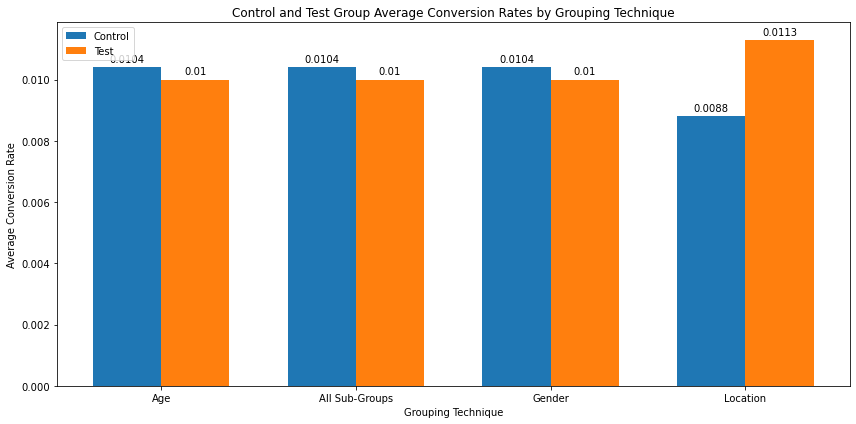

In [57]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

In [58]:
d1 = control_df.groupby('location').mean().conversion.sort_index().values.round(3)
d2 = test_df.groupby('location').mean().conversion.sort_index().values.round(3)

dlabels = ['Control', 'Test']
labels = list(set(control.location.values))
labels.sort()
xlabel = 'State'
ylabel = 'Conversion Rate'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group Conversion Rates by State'

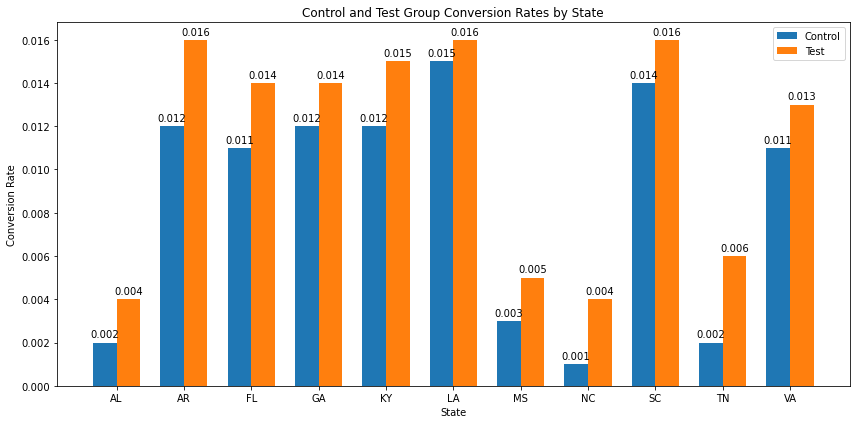

In [59]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

In [60]:
control_df.groupby('location').count().timestamp

location
AL    13459
AR    30787
FL    29321
GA    28570
KY    30010
LA    28865
MS    13855
NC    14118
SC    30446
TN    12994
VA    29682
Name: timestamp, dtype: int64

In [61]:
d1 = control_df.groupby('location').count().timestamp.sort_index().values.round(3)
d2 = test_df.groupby('location').count().timestamp.sort_index().values.round(3)

dlabels = ['Control', 'Test']
labels = list(set(control.location.values))
labels.sort()
xlabel = 'State'
ylabel = 'Requests'

x = np.arange(len(labels))
width = 0.35
xticks = [x, labels]

title = 'Control and Test Group Requests by State'

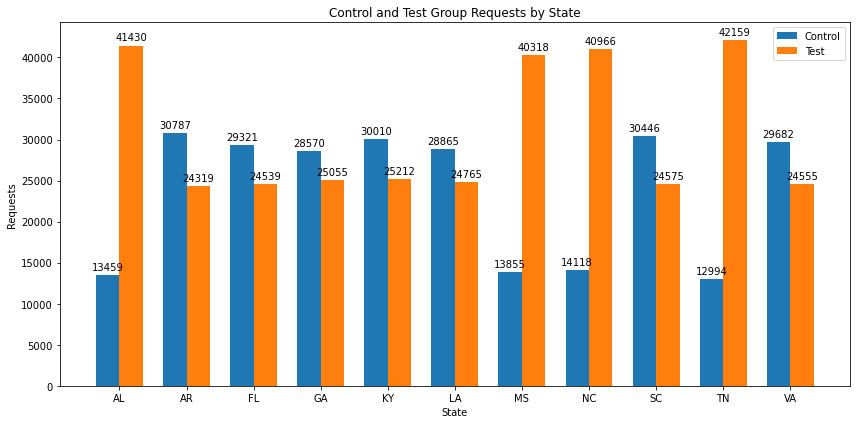

In [62]:
makeGroupedBars(d1, d2, x, dlabels, xticks, xlabel, ylabel, title)

In [63]:
trunctrl = control_df[~control_df['location'].isin(['AL', 'MS', 'NC', 'TN'])]
trunctest = test_df[~test_df['location'].isin(['AL', 'MS', 'NC', 'TN'])]
truncfull = full[~full['location'].isin(['AL', 'MS', 'NC', 'TN'])]

In [64]:
(test_df.conversion.mean() * 100) - (control_df.conversion.mean() * 100)

-0.03502060970857768

In [65]:
(trunctest.conversion.mean() * 100) - (trunctrl.conversion.mean() * 100)

0.2460778202231273

In [66]:
(control_df.conversion.mean() * 100) - (full.conversion.mean() * 100)

0.019722031460434053

In [67]:
(trunctrl.conversion.mean() * 100) - (truncfull.conversion.mean() * 100)

-0.11183680750774361

In [68]:
(test_df.conversion.mean() * 100) - (full.conversion.mean() * 100)

-0.015298578248143624

In [69]:
(trunctest.conversion.mean() * 100) - (truncfull.conversion.mean() * 100)

0.1342410127153837

# A / B Testing to Evaluate Campaign Performance

Comparing the conversion rate (mean conversion value for conversion column) for the control and test groups, we actually see a decline in conversion in the test group, suggesting that the new ad decreases conversion.

We can confirm whether this decrease happened by chance or was actually correlated to the new creative design by hypothesis testing our scenario.

In this case, the actual A/B test has already effectively been run and we have to evaluate the results of the test by considering campaign performance between the control and test groups.

## Experiment Design

Normally, such a test would be evaluated in terms of some practical significance boundary determined in consultation with various campaign stakeholders. **Since no practical significance boundary was specified in the assessment prompt, we will assume statistical significance is the practical significance boundary,** meaning that if the difference in conversion rate is statistically significant, this is practically significant for the business.

I want to start by looking at these data another way. Instead of starting with conversion rate, as above, I want to look at the raw numbers of visitors, bids and conversions in the control and test groups.

In [70]:
data = [[control_df.bid.sum(),
         control_df.win.sum(),
         control_df.conversion.sum()],
        [test_df.bid.sum(),
         test_df.win.sum(),
         test_df.conversion.sum()]]

In [71]:
truncdata = [[trunctrl.bid.sum(),
              trunctrl.win.sum(),
              trunctrl.conversion.sum()],
             [trunctest.bid.sum(),
              trunctest.win.sum(),
              trunctest.conversion.sum()]]

In [72]:
conv_df = pd.DataFrame(data, index=['control', 'test'], columns=['bids', 'wins', 'conversions'])

In [73]:
trunc_conv = pd.DataFrame(truncdata, index=['control', 'test'], columns=['bids', 'wins', 'conversions'])

In [74]:
conv_df

,bids,wins,conversions
control,130995,65564,2723
test,168846,84595,3392


In [75]:
trunc_conv

,bids,wins,conversions
control,103602,51812,2611
test,86280,43365,2601


In [76]:
def permutation_test(s, A, B):
    n = A + B
    iB = set(random.sample(range(n), B))
    iA = set(range(n)) - iB
    return s.loc[iB].mean() - s.loc[iA].mean()

In [77]:
def get_pt_diffs(df, resamples=1000, neg=True):
    if neg:
        obs_pct_diff = 100 * (df.iloc[0][1] / df.iloc[0][0] - df.iloc[1][1] / df.iloc[1][0])
    else:
        obs_pct_diff = 100 * (df.iloc[1][1] / df.iloc[1][0] - df.iloc[0][1] / df.iloc[0][0])
    conversion = [0] * (sum([df.iloc[0][0], df.iloc[1][0]]) - sum([df.iloc[0][1], df.iloc[1][1]]))
    conversion.extend([1] * sum([df.iloc[0][1], df.iloc[1][1]]))
    conversion = pd.Series(conversion)

    pt_diffs = [100 * permutation_test(conversion, df.iloc[0][0], df.iloc[1][0])
                for _ in range(resamples)]
    return pt_diffs, obs_pct_diff

In [78]:
pt_diffs, obs_pct_diff = get_pt_diffs(conv_df[['bids', 'wins']])

In [79]:
def make_perm_hist(diffs, obs_pct, title, placement):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(pt_diffs, bins=11, rwidth=0.9)
    ax.axvline(x=obs_pct_diff, color='black', lw=2)
    ax.text(placement[0], placement[1], f'Observed\nDifference\n= {round(obs_pct, 2)} percent', bbox={'facecolor': 'white'})
    ax.set_xlabel('Conversion rate (percent)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    
    plt.savefig(f'../images/{title.replace(" ", "_")}.png')
    
    plt.show();

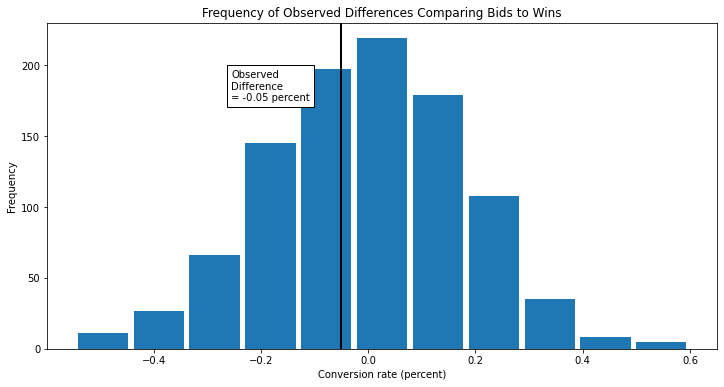

In [80]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Bids to Wins',
               [5*obs_pct_diff, 175])

In [81]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.609

In [82]:
def calc_pVal(df):
    survivors = np.array([[df.iloc[0][1], df.iloc[0][0] - df.iloc[0][1]],
                         [df.iloc[1][1], df.iloc[1][0] - df.iloc[1][1]]])
    chi2, pval, df2, _ = scs.chi2_contingency(survivors)
    
    return pval

In [83]:
calc_pVal(conv_df[['bids', 'wins']])

0.7841564209738942

In [84]:
pt_diffs, obs_pct_diff = get_pt_diffs(trunc_conv[['bids', 'wins']], neg=False)

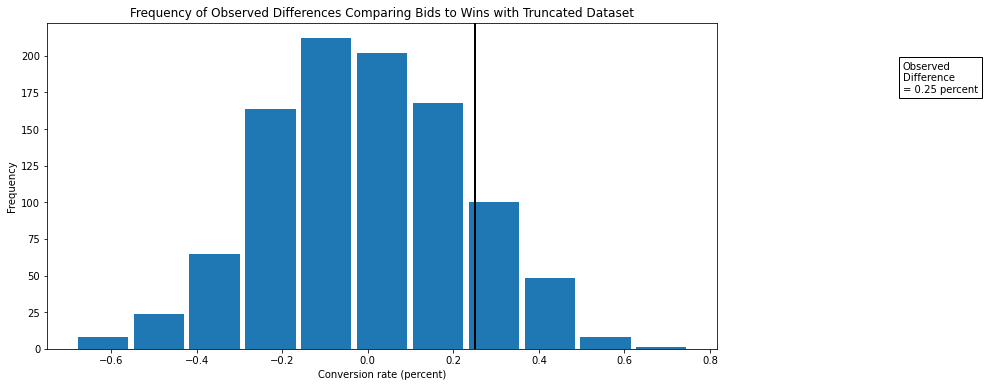

In [85]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Bids to Wins with Truncated Dataset',
               [5*obs_pct_diff, 175])

In [86]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.136

In [87]:
calc_pVal(trunc_conv[['bids', 'wins']])

0.27972459586566406

In [88]:
pt_diffs, obs_pct_diff = get_pt_diffs(conv_df[['wins', 'conversions']])

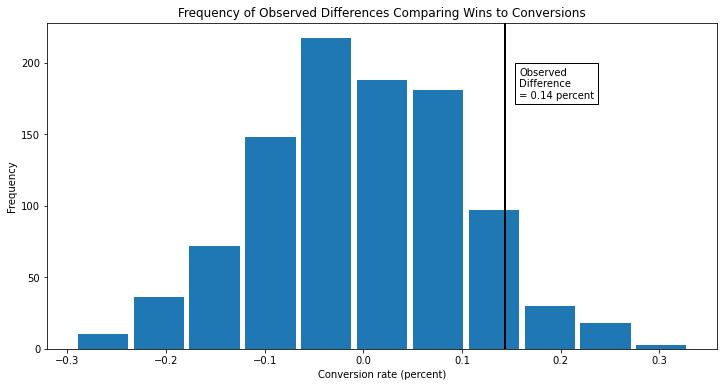

In [89]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Wins to Conversions',
               [1.1*obs_pct_diff, 175])

In [90]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.064

In [91]:
calc_pVal(conv_df[['wins', 'conversions']])

0.16690884512421925

In [92]:
pt_diffs, obs_pct_diff = get_pt_diffs(trunc_conv[['wins', 'conversions']], neg=False)

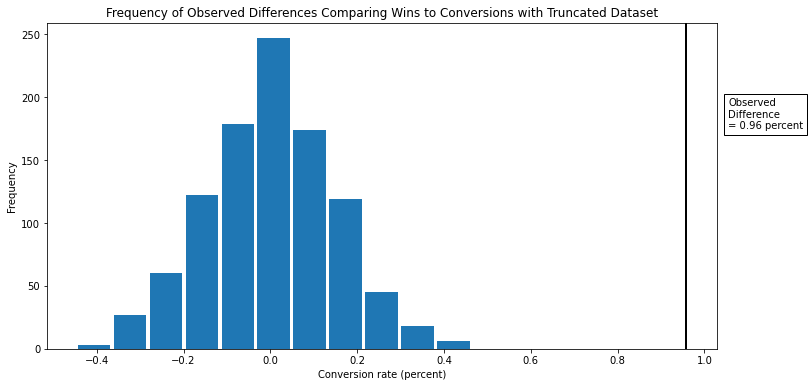

In [93]:
make_perm_hist(pt_diffs,
               obs_pct_diff,
               'Frequency of Observed Differences Comparing Wins to Conversions with Truncated Dataset',
               [1.1*obs_pct_diff, 175])

In [94]:
np.mean([diff > obs_pct_diff for diff in pt_diffs])

0.0

In [95]:
calc_pVal(trunc_conv[['wins', 'conversions']])

1.0538330348490972e-10